# Biogeophysical feedbacks: Daisy World

Acknowledgements:
Code is adapted from a python script by Andrew Bennett

## Introduction

Daisy world is a toy model of the planet designed to show how negative feedbacks with the biosphere can lead to a stable planet temperature over a wide range of solar luminosities. It was introduced by Watson and Lovelock (1983, Tellus B: Chemical and Physical Meteorology 35.4 (1983): 284-289., hereafter WL83) as an example of the Gaia theory, which proposed a solution to the weak young sun paradox. You are also referred to the excellent review paper, Wood et al. (2008), Rev. Geophys.,46, RG1001, doi:10.1029/2006RG000217, referred to W08 hereafter.

In the early stage of the planet, when life had already established, the sun was about 30\% weaker than today, and yet mean temperatures must have remained within the rough range of 0-40C which allow life to persist. The Gaia theory proposed a negative, "stabilizing feedback", whereby the presence of life reduces temperature variability, thus permitted the continued presence of life.

In response to criticism to the theory, WL83 introduced daisy world. Quite simply, a planet is occupied by two species of daisy with different albedos (see figure above), but the same temperature response function where growth is maximized at a certain temperature (22.5C in the paper).  Black daisies are warmer than white due to their lower albedo. 

The model is simple, consisting of two ODEs that describe the evolution of the black and white daisies as a function of the temperature and three diagnostic equations that describe mean albedo of the planet, the resulting mean temperature assuming energy balance, and the local temperatures of the daisy patches, which are a function of the flower albedo.

Before we start we need to import the modules we will need for the code, numpy and matplotlib for the graphics, and we define a few constants.

![Daisy world](https://personal.ems.psu.edu/~dmb53/Earth_System_Models/Daisyworld_files/Daisyworld_pict.jpg)

Daisyworld image from PSU, David Bice.

## The model
The model is simple, consisting of two ODEs that describe the evolution of the black and white daisies as a function of the temperature and three diagnostic equations that describe mean albedo of the planet, the resulting mean temperature assuming energy balance, and the local temperatures of the daisy patches, which are a function of the flower albedo.

Before we start we need to import the modules we will need for the code, numpy and matplotlib for the graphics, and we define a few constants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

keloff=273.15 # to convert between K and deg C 
sigma=5.67e-8 # S-B constant
S0=1000 # solar constant W/m**2
transport=20  # q' in equation 7 of WL83, lineared diffusion heat transport - this relates local albedo perturbations to temperature perturbations
maxloop=100 # number of iterations to allow daisies to equilibrate.
luminosity=np.arange(0.5,1.5,0.01) # range of luminosities over which we will loop, starting from low to high


## Plant response function

We now define the plant growth temperature response function.  This is a quadratic curve that peaks at T=22.5C (you may change this value).  

Equation 3 of WL83:
\begin{equation}
\beta=1-0.003265(22.5-T)^2
\end{equation}

The max function ensures positive-definite growth rates, setting the growth rate to zero below about 5C and above 40C.  NOTE: Be careful of the units for temperature, which switch between deg C and K in the code and paper. 

This plant response function is identical for both kinds of daisies, black and white, thus the difference in growth rates can only be due to their impact on the local temperature due to their albedo. 

Let's code up the temperature response function now, note that we also define the plant death rate, which is introduced in the equations below ($\gamma$):

In [2]:
Td_ideal=22.5+keloff  # peak growth rate for daisies
birth_rate_k=0.003265 #
death_rate=0.3 # fixed death rate gamma in equation 1
def birth_rate(T):
    """function to calculate birth rate"""
    return max(1.0-birth_rate_k*(Td_ideal-T)**2,0.0)

## The plant function types

We now introduce some other parameters in the model, the white daisy (dw) and black daisy (db) and bare soil (bs) albedoes: 

In [3]:
alb_dw=0.75 # white daisies albedo 
alb_db=0.25 # black daisies
alb_bs=0.5  # bare soil 

We perform the main loop over normalized luminosity values (so L=1 implies present day solar constant), and for each luminosity find the stable solution of daisy area and temperature.

The equations we solve in turn are:

Equation 5 of WL83, this simply states that the mean planetary albedo is an area-weighted average of the daisies and bare soil values. 

\begin{equation}
A_p=A_{dw}\alpha_{dw}+A_{db}\alpha_{db}+A_{bs}\alpha_{bs}
\end{equation}

where $\alpha$ is the fractional coverage of the white daisies (dw), black daises (db) or bare soil (bs) and $A$ is the respective albedo of each land cover type.  (NOTE: We use this notation to follow WL83 and W08, but do not get confused as we usually use $\alpha$ for albedo in the course).


We then calculate the planet mean temperature, which is a simple energy balance equation between incoming solar and emitted infrared radiation (Equation 4 of WL83):
\begin{equation}
T_e=\sqrt[4]{\frac{LS_0(1-A)}{\sigma}}
\end{equation}



The next step is to calculate the local temperature resulting from the presence of the daisies.  In WL83 this is not explained in much detail, and we thus refer to the excellent description of W08: The local temperatures $T_{dw}$ and $T_{db}$ and the bare soil temperature $T_{bs}$ are defined by making a simplifying assumption about the heat transfer, essentially a linearization of adiffusion term (refer to the 1D zonal model for ice albedo feedback). This gives a degree of connectedness to the daisy patches without introducing space explicitly. A parameter $q$ is defined as the heat transfer coefficient in WL83, thereby defining the local temperatures as (equation 7 of WL83 or 5-7 in W08):

\begin{equation}
T_{dw}=q(A-A_{dw})+T_e
\end{equation}
and similarly for the black daisies. 



Now we only have to define the two key equations, which describe the birthrate of each daisy type which is a function of their optimum temperatures, using the birthrate function defined above.  Each daisies has a constant death rate $\gamma$, converting daisy coverage back to bare soil. These equations are standard for population dynamics, disease models etc.  These are eqn. 1 in WL83 or eqn 2 in W08:

\begin{equation}
\frac {\partial \alpha_{dw}}{\partial t}=\alpha_{dw}(\alpha_{bs}\beta(T_{dw})-\gamma)
\end{equation}

\begin{equation}
\frac {\partial \alpha_{db}}{\partial t}=\alpha_{db}(\alpha_{bs}\beta(T_{db})-\gamma)
\end{equation}

In the code below we note the solver is not accurate, as the system is coupled and the integration method is explicit, but it simple to understand and will do for present purposes.  If you have finished the ICTP diploma course in numerical methods I/II you may like to replace this, implementing a Runge-Kutta 4th order solver for example. 

In [4]:
# store arrays 
area_dw_v=[]
area_db_v=[]
area_bs_v=[]
T_p_v=[]
T_ref=[]

area_dw=area_db=0.01 # initial conditions

# loop over luminosity...
for iflux,flux in enumerate(luminosity):
    # initial conditions are taken from a previous run, subject to 
    # a minimum of 1% in case the species had died out 
    area_dw=max(area_dw,0.01)   # white daisies can't die out
    area_db=max(area_db,0.01)   # black daises neither  
    area_bs=1.0-area_dw-area_db # bare soil fraction
    it=0
    while it<maxloop:  # can put tolerance to exit earlier if converged...
        it+=1
        
        # EQN 5: calculate weighted average albedo
        alb_p=area_dw*alb_dw+area_db*alb_db+area_bs*alb_bs
        
        # EQN 4: calculate planet mean temperature
        T_p=np.power(flux*S0*(1-alb_p)/sigma,0.25)
        
        # EQN 7: calculate local temperatures
        T_db=transport*(alb_p-alb_db)+T_p
        T_dw=transport*(alb_p-alb_dw)+T_p
       
        # EQN 3: calculate birth rate beta
        birth_rate_db=birth_rate(T_db)
        birth_rate_dw=birth_rate(T_dw)
        
        # EQN 1: change in daisy area
        area_db+=area_db*(birth_rate_db*area_bs-death_rate)
        area_dw+=area_dw*(birth_rate_dw*area_bs-death_rate)
        
        # update areas
        area_bs=1.0-area_db-area_dw

    # store the value...
    area_db_v.append(area_db)
    area_dw_v.append(area_dw)
    area_bs_v.append(area_bs)
    T_p_v.append(T_p)
    T_ref.append(np.power(flux*S0*(1-alb_bs)/sigma,0.25))


## Results

Now we just need to plot the results:

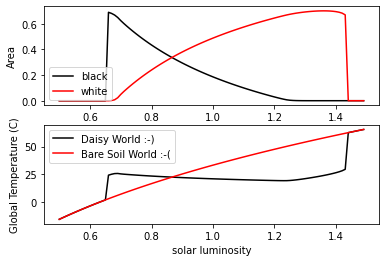

In [5]:
fig,ax=plt.subplots(2,1)
ax[0].plot(luminosity,area_db_v,color='black',label='black')
ax[0].plot(luminosity,area_dw_v,color='red',label='white')
ax[0].set_xlabel('solar luminosity')
ax[0].set_ylabel('Area')
ax[0].legend(loc="best")

ax[1].plot(luminosity,np.array(T_p_v)-keloff,color="black",label="Daisy World :-)")
ax[1].plot(luminosity,np.array(T_ref)-keloff,color="red",label="Bare Soil World :-(")
ax[1].set_xlabel('solar luminosity')
ax[1].set_ylabel('Global Temperature (C)')
ax[1].legend()


We see the very interesting behaviour of daisy world.  Once the black daisies are established, they locally increase the temperature, and as the luminosity increases in also allows white daisies to be established. Increases in luminosity in turn increase the proportion of white daisies, which reduce the local temperature due to the higher albedo (note, higher than bare soil).  The key take home of WL83 was that, relative to bare soil world (red line) the temperature is very stable.  In fact you will see when you carry out some of the exercises below that the two daisies type are actually mutually beneficial in the standard set up of these model, that is "cooperative", and can coexist across a far wider range of luminosity than is the case when a single species exists.  This perhaps has important implications for the importance of biodiversity on our planet! 

## Questions to investigate

<ol>
    <li> What happens if you change the albedo values of the black and/or white daisies?  Try altering the albedos but keeping $A_{db} < A_{bs} < A_{dw}$.  But then also try $A_{db} < A_{dw} < A_{bs}$ or $A_{bs} < A_{db} < A_{dw}$. </li>
    <li> Tinker with the daisy-dependent death rates and see what happens</li>
    <li> What happens if, after arriving at a luminosity $L$ of 1.6 you turn the sun back down again?  (i.e. reverse the luminosity loop). Do the solution branches follow each other exactly, or is there a hysteresis? Why? </li>
    <li>What happens if for each value of luminosity you start from a near bare earth? (1% coverage for each daisy type)  At which values of luminosity does the population crash occur?</li>
    <li>What happens if you only allow one daisy type? </li>
    <li>What happens if you introduce 3 (or more) daisy types? </li>
    <li> Watson and Lovelock introduce another experiment in which black daisies are warmer, but they cool the planet by introducing clouds.  This experiment can be conducted by assuming that the TOA albedo for black daisy areas is 0.8, the daises are still warmer than white daisies due to their lower albedo (not very physical!) - See if you can reproduce fig 2 of Watson and Lovelock with this experiment.  What happens to the white daisies?</li>
    <li>Can you introduce adaptation? You could apply random mutations to the constants in the $\beta$ plant growth function over time, perhaps introduces to a third type with a seed fraction at a particular time.  </li>
</ol>

Have fun and above all, never stop asking yourself "what if?"
